In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import numpy as np
import seaborn as sns

In [3]:
df = pd.read_csv('dwarves_output.csv')

In [4]:
df.shape

(167391, 20)

In [5]:
df.head(1)

,Full Fort Description,Fort Name,Biome,Coal Level,Copper available?,Gold available?,Hematite available?,Magnetite available?,Silver available?,Tin available?,Size of Expedition,Miners sent,Smiths sent,Woodcutters sent,Farmers sent,Brewers sent,Warriors sent,Crafters sent,Fort Survived?,Fort Value
0,Relicrope (Jungle; No Coal; Copper; Gold; Hema...,Relicrope,Jungle,0,1,1,1,0,1,0,13,2,2,1,4,1,3,0,1,312


## Consider irrelevant forts with more than 13 dwarves

In [6]:
df = df[df['Size of Expedition'] <= 13].copy()

In [7]:
df.shape

(62505, 20)

In [8]:
features = [
    'Miners sent', 
    'Smiths sent', 
    'Woodcutters sent',
    'Farmers sent', 
    'Brewers sent', 
    'Warriors sent', 
    'Crafters sent'
]

y_sur_label = 'Fort Survived?'
y_value_label = 'Fort Value'

This feature will be explained later

In [9]:
df['farmers_plus_brewers'] = df['Farmers sent'] + df['Brewers sent']

## First things first, leave the validation dataset

In [10]:
df_train, df_val = (
    train_test_split(df, test_size=0.2, random_state=42)
)

In [11]:
print(f'mean(y_sur_train) = {df_train["Fort Survived?"].mean():.3f}')
print(f'mean(y_sur_val) = {df_val["Fort Survived?"].mean():.3f}')
print(f'mean(y_value_train) = {df_train["Fort Value"].mean():.3f}')
print(f'mean(y_value_val) = {df_val["Fort Value"].mean():.3f}')

mean(y_sur_train) = 0.866
mean(y_sur_val) = 0.869
mean(y_value_train) = 141.005
mean(y_value_val) = 141.911


## Hypothesis. Condition to survive - Brewers + Farmers >= 3

In [12]:
farmers_brewers_stats = df_train.groupby('farmers_plus_brewers')['Fort Survived?'].agg(['mean', 'count']).reset_index()

In [13]:
farmers_brewers_stats

,farmers_plus_brewers,mean,count
0,0,0.036542,1122
1,1,0.357498,4621
2,2,0.708633,9047
3,3,0.998751,11208
4,4,0.999707,10246
5,5,1.000000,7381
6,6,0.999745,3919
7,7,1.000000,1721
8,8,1.000000,551
9,9,1.000000,147


## Consider only cases with Brewers + Farmers >= 3

In [14]:
df_train = df_train[df_train['farmers_plus_brewers'] >= 3]
df_val = df_val[df_val['farmers_plus_brewers'] >= 3]

Check that train/val proportion is still 4 to 1

In [15]:
df_val.shape[0] / (df_val.shape[0] + df_train.shape[0])

0.20258152173913044

In [16]:
df_train.shape

(35214, 21)

## Fit the model

Target distribution

<AxesSubplot:xlabel='Fort Value'>

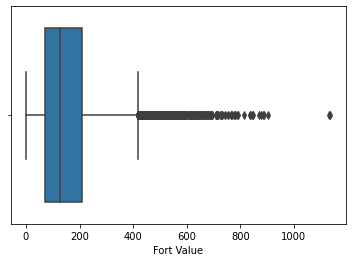

In [32]:
sns.boxplot(x=df_train['Fort Value'])

In [36]:
lgb.LGBMRegressor?

In [47]:
model = lgb.LGBMRegressor(
    max_depth=5
)

In [48]:
model.fit(df_train[features], df_train['Fort Value'], 
          eval_set=[
              (df_train[features], df_train['Fort Value']), 
              (df_val[features], df_val['Fort Value'])],
          eval_metric='rmse'
)

[1]	valid_0's rmse: 106.283	valid_0's l2: 11296.1	valid_1's rmse: 105.714	valid_1's l2: 11175.4
[2]	valid_0's rmse: 100.564	valid_0's l2: 10113.2	valid_1's rmse: 99.9324	valid_1's l2: 9986.49
[3]	valid_0's rmse: 95.6637	valid_0's l2: 9151.54	valid_1's rmse: 94.9618	valid_1's l2: 9017.74
[4]	valid_0's rmse: 91.4962	valid_0's l2: 8371.55	valid_1's rmse: 90.759	valid_1's l2: 8237.19
[5]	valid_0's rmse: 87.9582	valid_0's l2: 7736.65	valid_1's rmse: 87.1758	valid_1's l2: 7599.63
[6]	valid_0's rmse: 84.9525	valid_0's l2: 7216.93	valid_1's rmse: 84.1524	valid_1's l2: 7081.62
[7]	valid_0's rmse: 82.4164	valid_0's l2: 6792.46	valid_1's rmse: 81.6209	valid_1's l2: 6661.98
[8]	valid_0's rmse: 80.3025	valid_0's l2: 6448.49	valid_1's rmse: 79.5199	valid_1's l2: 6323.41
[9]	valid_0's rmse: 78.4997	valid_0's l2: 6162.2	valid_1's rmse: 77.7177	valid_1's l2: 6040.05
[10]	valid_0's rmse: 76.9926	valid_0's l2: 5927.87	valid_1's rmse: 76.2098	valid_1's l2: 5807.93
[11]	valid_0's rmse: 75.7176	valid_0's l2

LGBMRegressor(max_depth=5)

## Genetic search

In [264]:
def get_first_gen(n_samples):
    n_feat = 7
    res = np.empty((n_samples, n_feat))
    for i in range(n_samples):
        while True:
            m_left = 13
            order = np.random.choice(np.arange(n_feat), size=n_feat, replace=False)
            for j in order:
                res[i, j] = np.random.randint(m_left + 1)
                m_left -= res[i, j]
            res[i, order[-1]] = m_left
            if res[i, 3] + res[i, 4] >= 3:
                break
    return res

In [271]:
def mutate(x, n_childs, n_changes):
    n_feats = 7
    res = np.empty((x.shape[0] * (n_childs + 1), x.shape[1]))
    for i in range(len(x)):
        for j in range(n_childs):
            res[i * n_childs + j] = x[i]
            for _ in range(n_changes):
                k, l = list(np.random.choice(np.arange(n_feats), size=2, replace=False))
                if res[i * n_childs + j, l] == 0:
                    continue
                res[i * n_childs + j, k] += 1
                res[i * n_childs + j, l] -= 1
                if res[i * n_childs + j, 3] + res[i * n_childs + j, 4] < 3:
                    res[i * n_childs + j, k] -= 1
                    res[i * n_childs + j, l] += 1
    res[x.shape[0] * n_childs:] = x
    return res

In [283]:
x = get_first_gen(100)
for _ in range(20):
    x = mutate(x, 10, np.random.choice(np.arange(8)))
    y_pred = model.predict(x)
    idx = np.argsort(y_pred)[::-1][:10]
    print(f'Best predicted = {max(y_pred):.2f}, top combination = {x[idx[0]]}')
    top = x[idx[0]]
    x = x[idx]

Best predicted = 506.53, top combination = [6. 2. 0. 0. 4. 0. 0.]
Best predicted = 563.28, top combination = [6. 2. 0. 1. 2. 0. 2.]
Best predicted = 592.92, top combination = [6. 2. 0. 1. 2. 1. 1.]
Best predicted = 592.92, top combination = [6. 2. 0. 1. 2. 1. 1.]
Best predicted = 592.92, top combination = [6. 2. 0. 1. 2. 1. 1.]
Best predicted = 592.92, top combination = [6. 2. 0. 1. 2. 1. 1.]
Best predicted = 592.92, top combination = [6. 2. 0. 1. 2. 1. 1.]
Best predicted = 592.92, top combination = [6. 2. 0. 1. 2. 1. 1.]
Best predicted = 592.92, top combination = [6. 2. 0. 1. 2. 1. 1.]
Best predicted = 592.92, top combination = [6. 2. 0. 1. 2. 1. 1.]
Best predicted = 592.92, top combination = [6. 2. 0. 1. 2. 1. 1.]
Best predicted = 592.92, top combination = [6. 2. 0. 1. 2. 1. 1.]
Best predicted = 592.92, top combination = [6. 2. 0. 1. 2. 1. 1.]
Best predicted = 592.92, top combination = [6. 2. 0. 1. 2. 1. 1.]
Best predicted = 592.92, top combination = [6. 2. 0. 1. 2. 1. 1.]
Best predi

In [273]:
for i, f in enumerate(features):
    print(features[i], f'{top[i]:.0f}')

Miners sent 6
Smiths sent 2
Woodcutters sent 0
Farmers sent 1
Brewers sent 2
Warriors sent 1
Crafters sent 1
